In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


## Import

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from datetime import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, f1_score, precision_recall_curve
from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

RANDOM_SEED = 42

!pip freeze > requirements.txt

## Вспомогательные функции

In [4]:
def get_metrics(Y_test, Y_pred):
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f_score = f1_score(Y_test, Y_pred)
    
    print('\n Accuracy: {} \n'.format(round(accuracy, 3)),
          'Precision: {} \n'.format(round(precision, 3)),
          'Recall: {} \n'.format(round(recall, 3)),
          'F1_score: {}'.format(round(f_score, 3)))

    
def plot_roc_auc(Y_test, Y_prob):
    roc_auc = roc_auc_score(Y_test, Y_prob)
    fpr, tpr, threshold = roc_curve(Y_test, Y_prob)

    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], "b", label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, "r-", label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    
def plot_pr_curve(Y_test, Y_prob):
    precision, recall, threshold = precision_recall_curve(Y_test, Y_prob)
    
    plt.figure(figsize=(10, 7))
    plt.plot(threshold, precision[:-1], "r-", label="Precision")
    plt.plot(threshold, recall[:-1], "b", label="Recall")
    plt.xlabel("threshold")
    plt.legend(loc='upper right')
    plt.show()

    
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
# Объединение для предобработки
df_train['train'] = 1

df_test['train'] = 0
df_test['default'] = 0

df = df_train.append(df_test, sort=False).reset_index(drop=True)

## Feature sorting

In [7]:
list(df.columns)

['client_id',
 'app_date',
 'education',
 'sex',
 'age',
 'car',
 'car_type',
 'decline_app_cnt',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'region_rating',
 'home_address',
 'work_address',
 'income',
 'sna',
 'first_time',
 'foreign_passport',
 'default',
 'train']

In [8]:
# categorical variables
categorical = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# numerical variables
numerical = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
# binary variables
binary = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

## Preprocessing

In [9]:
# app_date - дата подачи заявки
##Преобразуем object → date
df['app_date'] = pd.to_datetime(df['app_date'])
## Извлечем month, day
df['app_date_month'] = df['app_date'].apply(lambda x: x.month)
df['app_date_day'] = df['app_date'].apply(lambda x: x.day)

In [10]:
# score_bki - скоринговый балл по данным из БКИ
## 12 значении из 110148 положительные числа.
## Так как медот подсчета параметра "неизвестен", предположим,
## что имеем дело с ошибкой и приведем все значения к "единому" виду
df['score_bki'] = df['score_bki'].apply(lambda x: abs(x))

In [11]:
def modify_df(df_input, bin_col, cat_col, num_col, scaler):
    
    df_output = df_input.copy()
    
    # Заполняем пропуски
    imputer = SimpleImputer(strategy='most_frequent')
    df[cat_col] = imputer.fit_transform(df[cat_col])
    
    # Binary variables
    
    for bf in bin_col:
        le = LabelEncoder()
        if df_output[bf].dtypes == object:
            # Кодируем
            df_output[bf] = le.fit_transform(df_output[bf])
    
    
    # Categorical variables
    
    for cf in cat_col:
        # Обнуляем le.classes_
        le = LabelEncoder()
        if df_output[cf].dtypes == object:
            # Кодируем
            df_output[cf] = le.fit_transform(df_output[cf])
            # Раскидаваем по столбцам
            df_temp = pd.get_dummies(df_output[cf])
            df_temp.columns = le.classes_
            # Добавляем в df
            df_output = df_output.merge(df_temp, left_index=True, right_index=True)
        else:
            # Раскидаваем по столбцам
            df_temp = pd.get_dummies(df_output[cf])
            names = []
            for i in list(df_temp.columns):
                names.append('{}_{}'.format(cf, i))
            df_temp.columns = names
            # Добавляем в df
            df_output = df_output.merge(df_temp, left_index=True, right_index=True)
    
    
    # Numerical variables
    
    for nf in num_col:
        df_output['{}_norm'.format(nf)] = scaler.fit_transform(df_output[[nf]])
        df_output['{}_log'.format(nf)] = df_output[nf].apply(lambda x: np.log(x+1))
        df_output['{}_log_norm'.format(nf)] = scaler.fit_transform(df_output[['{}_log'.format(nf)]])
    
    
    return df_output

In [12]:
df_n = modify_df(df, binary, categorical, numerical, scaler=StandardScaler())
df_n.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_date_month,app_date_day,ACD,GRD,PGR,SCH,UGR,NaN,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,age_norm,age_log,age_log_norm,decline_app_cnt_norm,decline_app_cnt_log,decline_app_cnt_log_norm,score_bki_norm,score_bki_log,score_bki_log_norm,bki_request_cnt_norm,bki_request_cnt_log,bki_request_cnt_log_norm,income_norm,income_log,income_log_norm
80557,29881,2014-02-05,3,0,53,1,1,0,0,1.812629,0,50,1,1,1000000,1,2,0,0,0,2,5,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1.193834,3.988984,1.173250,-0.341893,0.000000,-0.418815,-0.184124,1.034120,-0.089633,-0.884463,0.000000,-1.334144,21.123289,13.815512,4.980702
87957,98162,2014-04-15,1,1,38,1,1,0,0,2.524867,2,40,2,3,50000,1,4,0,0,0,4,15,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,-0.108474,3.663562,0.031629,-0.341893,0.000000,-0.418815,1.242365,1.259843,1.150541,-0.002207,1.098612,0.333797,0.197961,10.819798,0.680425
20293,96513,2014-04-13,4,1,56,1,0,0,0,2.142486,2,60,1,2,30000,3,1,0,0,1,4,13,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1.454295,4.043051,1.362924,-0.341893,0.000000,-0.418815,0.476522,1.145014,0.519646,-0.002207,1.098612,0.333797,-0.242572,10.308986,-0.052834
90061,73826,2014-03-21,3,0,46,0,0,1,0,2.138317,3,40,3,2,17000,1,4,0,0,0,3,21,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0.586090,3.850148,0.686195,0.909522,0.693147,1.499512,0.468171,1.143687,0.512351,0.438921,1.386294,0.770563,-0.528918,9.741027,-0.868125
28645,55415,2014-03-04,1,1,25,0,0,0,0,2.589511,1,80,2,2,80000,1,4,1,0,1,3,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,-1.237142,3.258097,-1.390791,-0.341893,0.000000,-0.418815,1.371834,1.278016,1.250388,-0.443335,0.693147,-0.281790,0.858761,11.289794,1.355094


## Feature engineering

In [13]:
# decline_app_cnt - количество отказанных прошлых заявок
## Распределение сильно не равномерное,однако распределение совершенно четко делится на 3 группы
## (Заемщиков с 2 отказами на порядок меньше чем с одним. Практически та же картина с 1 отказ/без отказов)
### Поделим на три группы
### 0 - без отказов, 1 - 1 отказ, 2 - 2 и более отказов
df_n['decline_app_cnt_group'] = df_n['decline_app_cnt'].apply(lambda x: 2 if x>=2 else 1 if x==1 else 0)
# Раскидаваем по столбцам
df_decline_app_cnt = pd.get_dummies(df_n['decline_app_cnt_group'])
df_decline_app_cnt.columns = ['no_decline', '1_decline', 'mm_decline']
# Добавляем
df_n = df_n.merge(df_decline_app_cnt, left_index=True, right_index=True)

In [14]:
list(df_n.columns)

['client_id',
 'app_date',
 'education',
 'sex',
 'age',
 'car',
 'car_type',
 'decline_app_cnt',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'region_rating',
 'home_address',
 'work_address',
 'income',
 'sna',
 'first_time',
 'foreign_passport',
 'default',
 'train',
 'app_date_month',
 'app_date_day',
 'ACD',
 'GRD',
 'PGR',
 'SCH',
 'UGR',
 nan,
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'age_norm',
 'age_log',
 'age_log_norm',
 'decline_app_cnt_norm',
 'decline_app_cnt_log',
 'decline_app_cnt_log_norm',
 'score_bki_norm',
 'score_bki_log',
 'score_bki_log_norm',
 'bki_request_cnt_norm',
 'bki_request_cnt_log',
 'bki_request_cnt_log_norm',
 'income_norm',


In [15]:
drop_list = ['client_id',
             'default',
             'app_date',
             'education',
#              'sex',
             'age',
#              'car',
#              'car_type',
             'decline_app_cnt',
#              'good_work',
             'score_bki',
             'bki_request_cnt',
             'region_rating',
             'home_address',
             'work_address',
             'income',
             'sna',
             'first_time',
#              'foreign_passport',
             'app_date_month',
             'app_date_day',
#              'ACD',
#              'GRD',
#              'PGR',
#              'SCH',
#              'UGR',
#              'region_rating_20',
#              'region_rating_30',
#              'region_rating_40',
#              'region_rating_50',
#              'region_rating_60',
#              'region_rating_70',
#              'region_rating_80',
#              'home_address_1',
#              'home_address_2',
#              'home_address_3',
#              'work_address_1',
#              'work_address_2',
#              'work_address_3',
#              'sna_1',
#              'sna_2',
#              'sna_3',
#              'sna_4',
#              'first_time_1',
#              'first_time_2',
#              'first_time_3',
#              'first_time_4',
             'age_norm',
             'age_log',
#              'age_log_norm',
             'decline_app_cnt_norm',
             'decline_app_cnt_log',
             'decline_app_cnt_log_norm',
             'score_bki_norm',
             'score_bki_log',
#              'score_bki_log_norm',
             'bki_request_cnt_norm',
             'bki_request_cnt_log',
#              'bki_request_cnt_log_norm',
             'income_norm',
             'income_log',
#              'income_log_norm',
             'decline_app_cnt_group',
#              'no_decline',
#              '1_decline',
#              'mm_decline'
            ]

## Подготовка данных

In [16]:
train_data = df_n.query('train == 1').drop(['train'], axis=1)
test_data = df_n.query('train == 0').drop(['train'], axis=1)

In [17]:
Y = train_data.default.values
X = train_data.drop(drop_list, axis=1)

## Подготовка данных к машинному обучению

In [18]:
# Чтобы решить проблему дисбаланса классов, можно использовать Over или UnderSampling
# Используем UnderSampling
rus = RandomUnderSampler(random_state = RANDOM_SEED)
X_resampled, Y_resampled = rus.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=RANDOM_SEED)

## LogisticRegression

In [19]:
# LogisticRegression
model = LogisticRegression(random_state = RANDOM_SEED)
model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]

### Metrics

In [20]:
get_metrics(Y_test, Y_pred)


 Accuracy: 0.678 
 Precision: 0.671 
 Recall: 0.689 
 F1_score: 0.68


### ROC-AUC

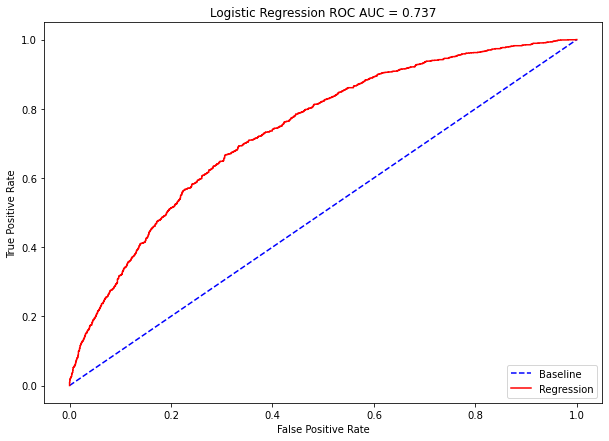

In [21]:
plot_roc_auc(Y_test, Y_prob)

### PR-curve

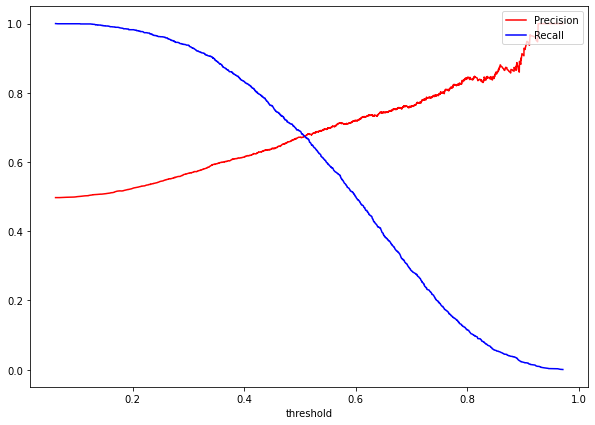

In [22]:
plot_pr_curve(Y_test, Y_prob)

### Confusion matrix

Normalized confusion matrix
[[0.66719661 0.33280339]
 [0.31095596 0.68904404]]


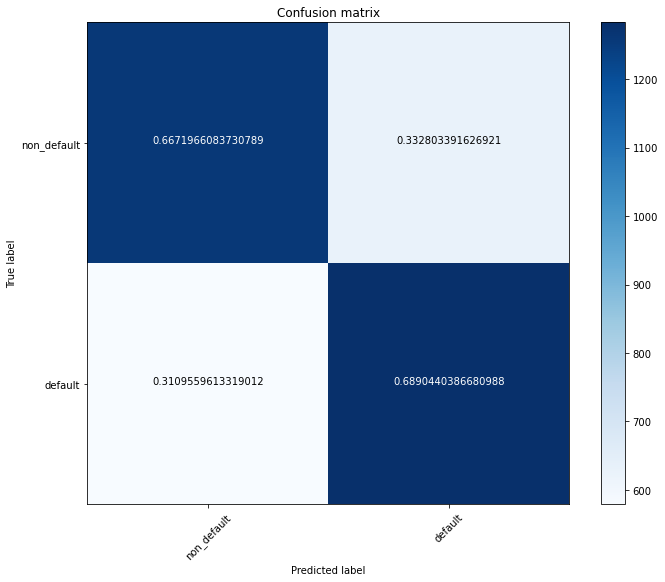

In [23]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

## LogisticRegression + Regularization

In [24]:
C = np.logspace(0.01, 2, 15)

param_grid = [{'penalty': ['l1'],
               'C': C,
               'solver': ['liblinear', 'lbfgs'],
               'multi_class': ['auto', 'ovr']},
              {'penalty': ['l2'],
               'C': C,
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'multi_class': ['auto', 'ovr']},
              {'penalty': ['none'],
               'C': C,
               'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'multi_class': ['auto', 'ovr']}
             ]

clf = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=True)

best_model = clf.fit(X_train, Y_train)
best_model = best_model.best_estimator_.get_params()


C = best_model['C']
penalty = best_model['penalty']
solver = best_model['solver']
multi_class = best_model['multi_class']
class_weight = best_model['class_weight']

best_model

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


{'C': 51.96540133151923,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [25]:
# LogisticRegression
model = LogisticRegression(C=C,
                           penalty=penalty,
                           solver=solver,
                           multi_class=multi_class,
                           class_weight=class_weight,
                           n_jobs=-1,
                           random_state=RANDOM_SEED)

model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]

### Metrics

In [26]:
get_metrics(Y_test, Y_pred)


 Accuracy: 0.678 
 Precision: 0.671 
 Recall: 0.689 
 F1_score: 0.68


### ROC-AUC

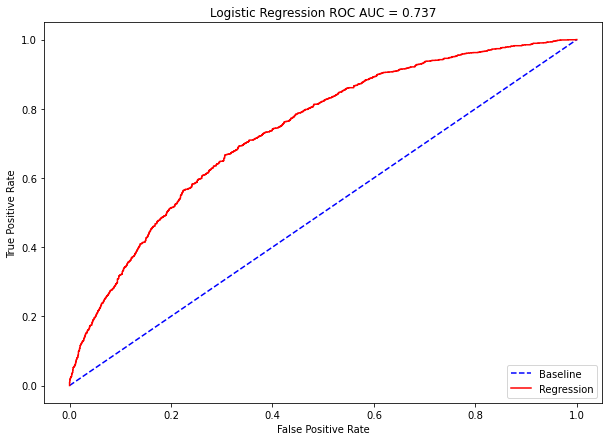

In [27]:
plot_roc_auc(Y_test, Y_prob)

### PR-curve

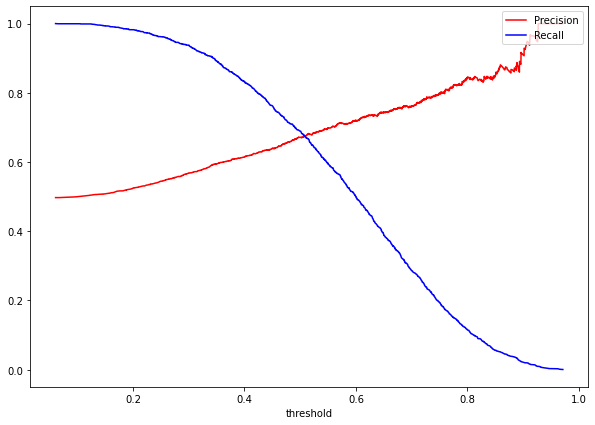

In [28]:
plot_pr_curve(Y_test, Y_prob)

### Confusion matrix

Normalized confusion matrix
[[0.66719661 0.33280339]
 [0.31095596 0.68904404]]


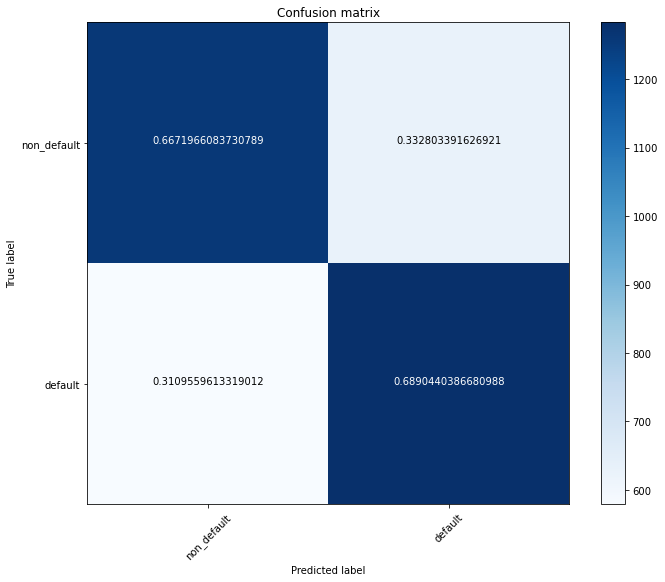

In [29]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

## LogisticRegression + Cross-validation

In [30]:
# LogisticRegressionCV
model = LogisticRegressionCV(cv=5, random_state = RANDOM_SEED)
model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:,1]

### Metrics

In [31]:
get_metrics(Y_test, Y_pred)


 Accuracy: 0.678 
 Precision: 0.671 
 Recall: 0.689 
 F1_score: 0.68


### ROC-AUC

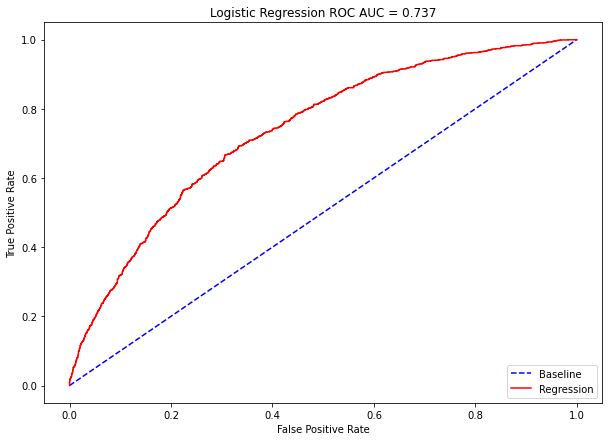

In [32]:
plot_roc_auc(Y_test, Y_prob)

### PR-curve

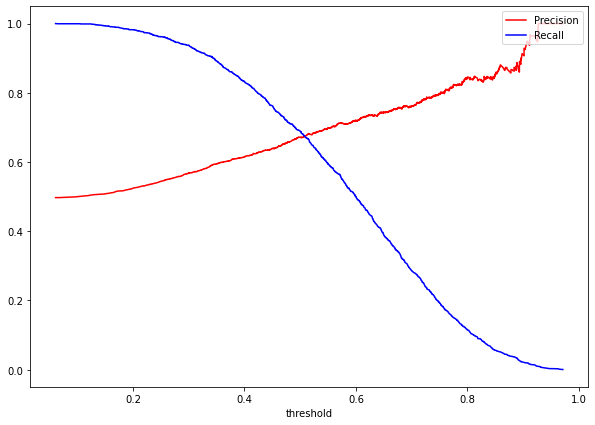

In [33]:
plot_pr_curve(Y_test, Y_prob)

### Confusion matrix

Normalized confusion matrix
[[0.66719661 0.33280339]
 [0.31095596 0.68904404]]


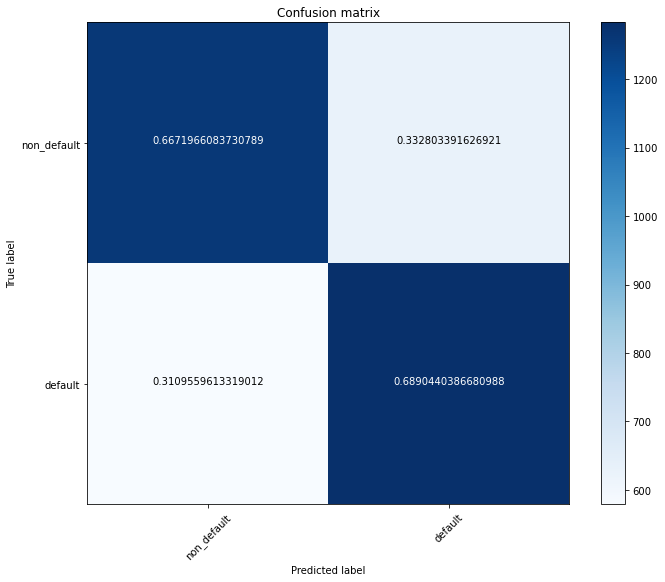

In [34]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

## LogisticRegression + Cross-validation + Regularization

In [35]:
Cs = [np.logspace(0.01, 2, 15)]
epsilon = [1e-2]
param_grid = [{'penalty': ['l1'],
               'Cs': Cs,
               'tol': epsilon,
               'solver': ['liblinear', 'saga'],
               'class_weight': ['None', 'balanced'],
               'multi_class': ['auto', 'ovr']},
              {'penalty': ['l2'],
               'Cs': Cs,
               'tol': epsilon,
               'solver': ['newton-cg', 'lbfgs', 'sag'],
               'class_weight': ['None', 'balanced'],
               'multi_class': ['auto', 'ovr', 'multinomial']},
              {'penalty': ['elasticnet'],
               'Cs': Cs,
               'tol': epsilon,
               'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
               'class_weight': ['None', 'balanced'],
               'multi_class': ['auto', 'ovr']}
              ]

model = LogisticRegressionCV()
clf = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, verbose=True)

best_model = clf.fit(X_train, Y_train)
best_model = best_model.best_estimator_.get_params()

Cs = best_model['Cs']
penalty = best_model['penalty']
solver = best_model['solver']
multi_class = best_model['multi_class']

best_model

Fitting 5 folds for each of 46 candidates, totalling 230 fits


{'Cs': array([  1.02329299,   1.41952438,   1.96918135,   2.73167213,
          3.78940853,   5.25671323,   7.29217601,  10.11579454,
         14.03275223,  19.46640319,  27.00402936,  37.46031531,
         51.96540133,  72.08703166, 100.        ]),
 'class_weight': 'None',
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'sag',
 'tol': 0.01,
 'verbose': 0}

In [36]:
# LogisticRegressionCV
model = LogisticRegressionCV(Cs=Cs,
                             penalty=penalty,
                             multi_class=multi_class,
                             solver=solver,
                             cv=5,
                             n_jobs=-1,
                             random_state=RANDOM_SEED)

model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]

### Metrics

In [37]:
get_metrics(Y_test, Y_pred)


 Accuracy: 0.678 
 Precision: 0.671 
 Recall: 0.689 
 F1_score: 0.68


### ROC-AUC

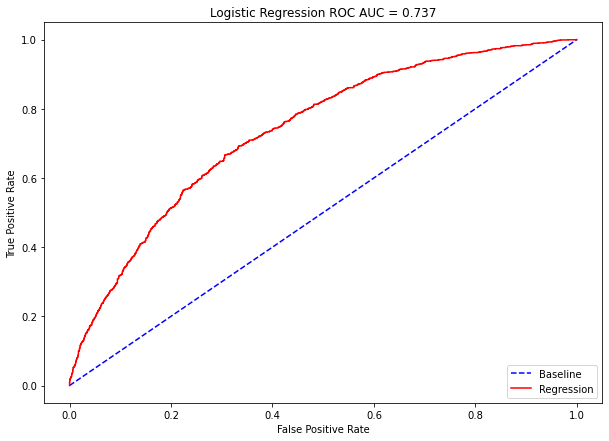

In [38]:
plot_roc_auc(Y_test, Y_prob)

### PR-curve

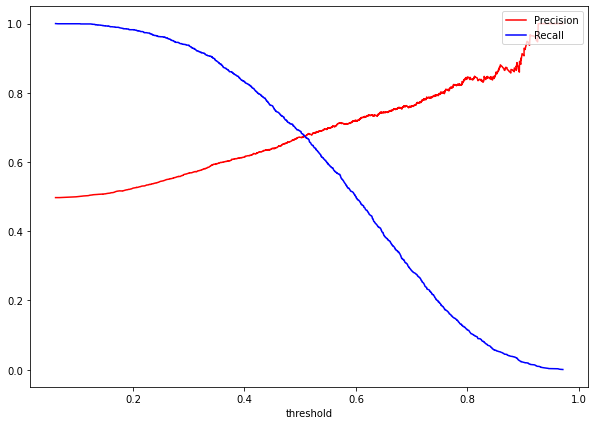

In [39]:
plot_pr_curve(Y_test, Y_prob)

### Confusion matrix

Normalized confusion matrix
[[0.66719661 0.33280339]
 [0.31095596 0.68904404]]


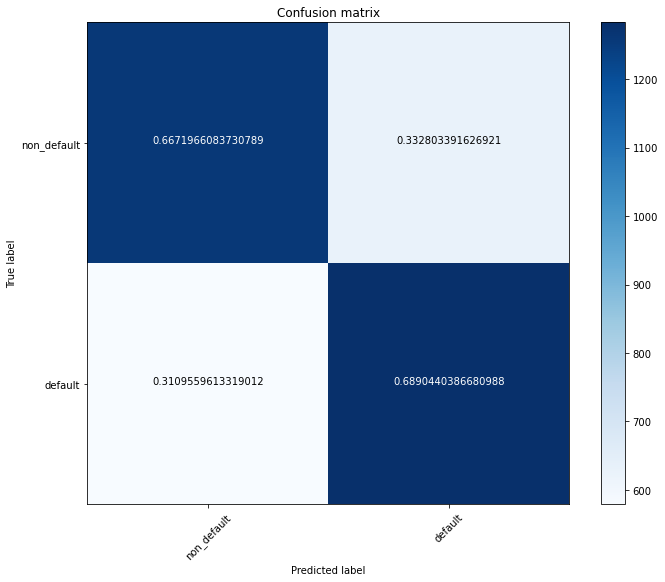

In [40]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

## Decision Tree Regressor

In [41]:
model = DecisionTreeClassifier(random_state=RANDOM_SEED)

model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]


 Accuracy: 0.561 
 Precision: 0.558 
 Recall: 0.56 
 F1_score: 0.559


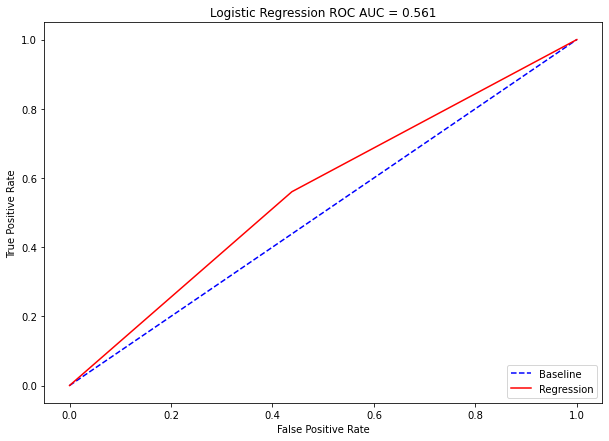

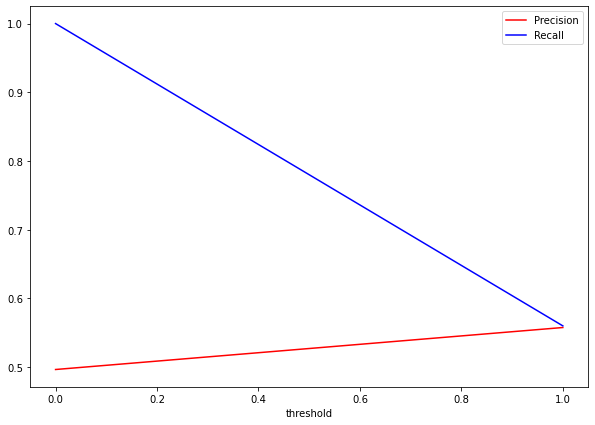

Normalized confusion matrix
[[0.56173821 0.43826179]
 [0.43984962 0.56015038]]


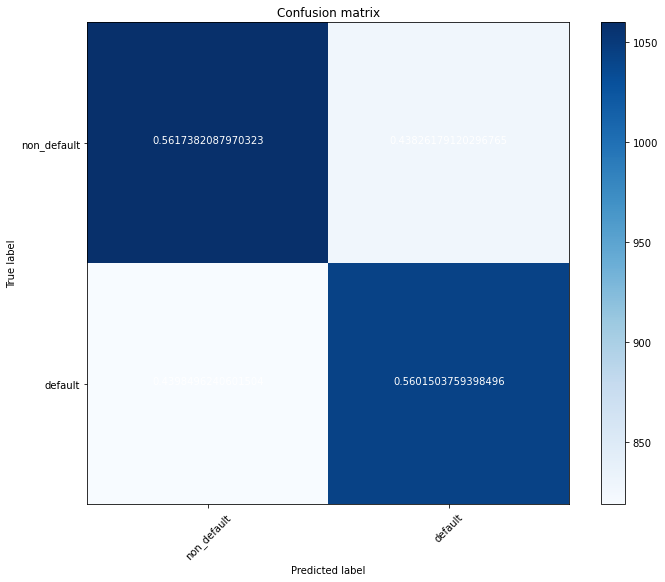

In [42]:
get_metrics(Y_test, Y_pred)


plot_roc_auc(Y_test, Y_prob)


plot_pr_curve(Y_test, Y_prob)


cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

## RandomForestClassifier

In [43]:
model = RandomForestClassifier(n_jobs= -1,
                               random_state=RANDOM_SEED,
                               ccp_alpha = 0.0,
                               max_depth = 4,
                               max_features = "auto",
                               max_leaf_nodes = 9,
                               n_estimators = 15,
                               oob_score = False)

model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]


 Accuracy: 0.655 
 Precision: 0.646 
 Recall: 0.676 
 F1_score: 0.661


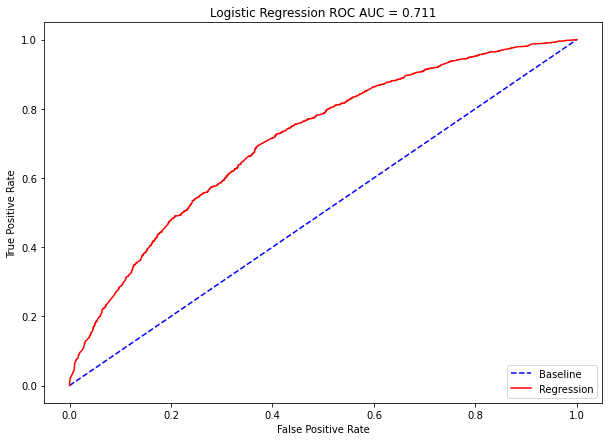

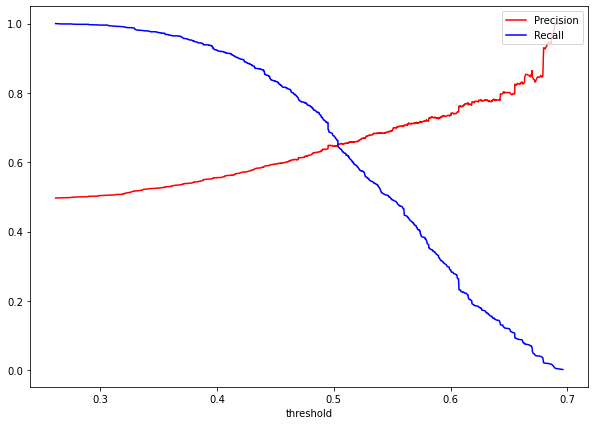

Normalized confusion matrix
[[0.63540011 0.36459989]
 [0.32438238 0.67561762]]


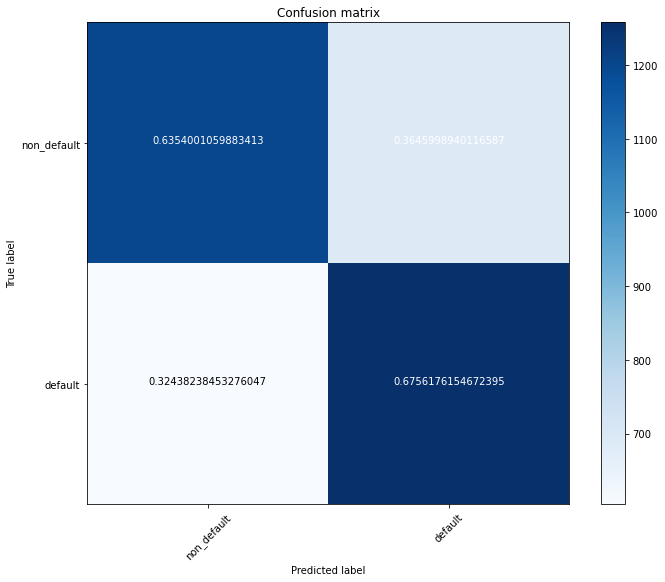

In [44]:
get_metrics(Y_test, Y_pred)


plot_roc_auc(Y_test, Y_prob)


plot_pr_curve(Y_test, Y_prob)


cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

## XGBoostClassifier

In [45]:
model = XGBClassifier(n_jobs= -1,
                      random_state=RANDOM_SEED,
                      eta = 0.02,
                      max_depth = 8,
                      n_estimators = 100,
                      sampling_method = 'uniform',
                      tree_method = 'auto')

model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]

[16:57:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



 Accuracy: 0.671 
 Precision: 0.66 
 Recall: 0.694 
 F1_score: 0.677


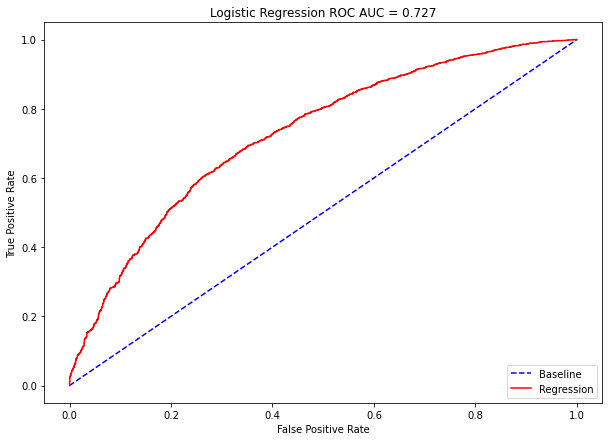

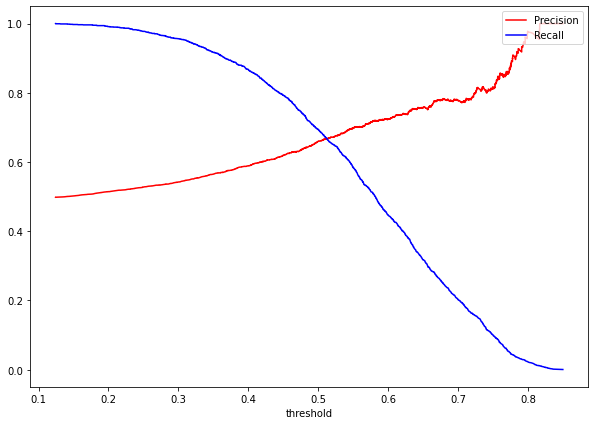

Normalized confusion matrix
[[0.64705882 0.35294118]
 [0.30558539 0.69441461]]


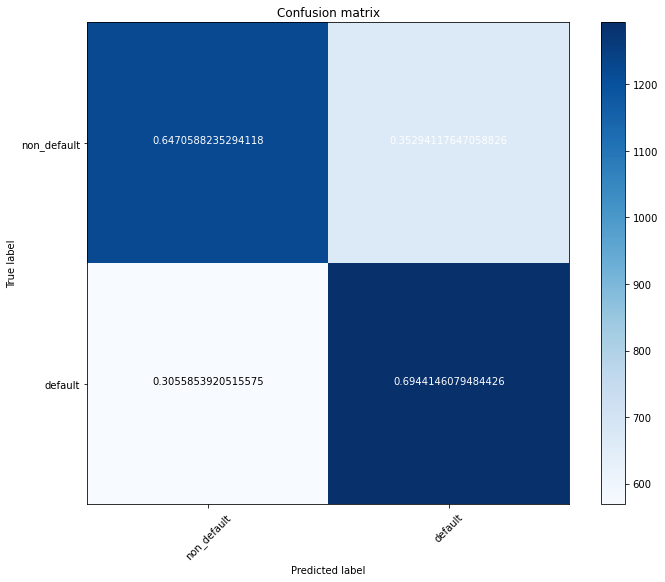

In [46]:
get_metrics(Y_test, Y_pred)


plot_roc_auc(Y_test, Y_prob)


plot_pr_curve(Y_test, Y_prob)


cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

## LGBM Classifier

In [47]:
model = LGBMClassifier(n_jobs= -1,
                       random_state=RANDOM_SEED,
                       eta = 0.01,
                       max_depth = 4,
                       n_estimators = 50,
                       sampling_method = 'uniform',
                       tree_method = 'auto')

model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Probability
Y_prob = model.predict_proba(X_test)
Y_prob = Y_prob[:, 1]

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1



 Accuracy: 0.676 
 Precision: 0.665 
 Recall: 0.701 
 F1_score: 0.683


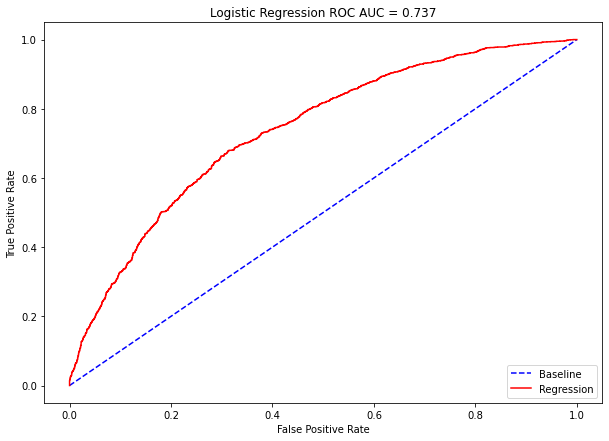

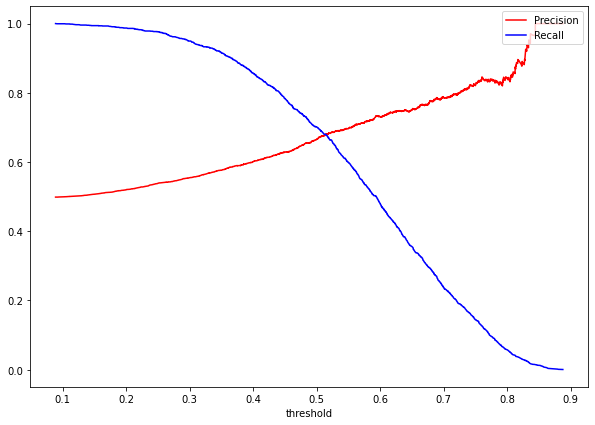

Normalized confusion matrix
[[0.6518283  0.3481717 ]
 [0.29860365 0.70139635]]


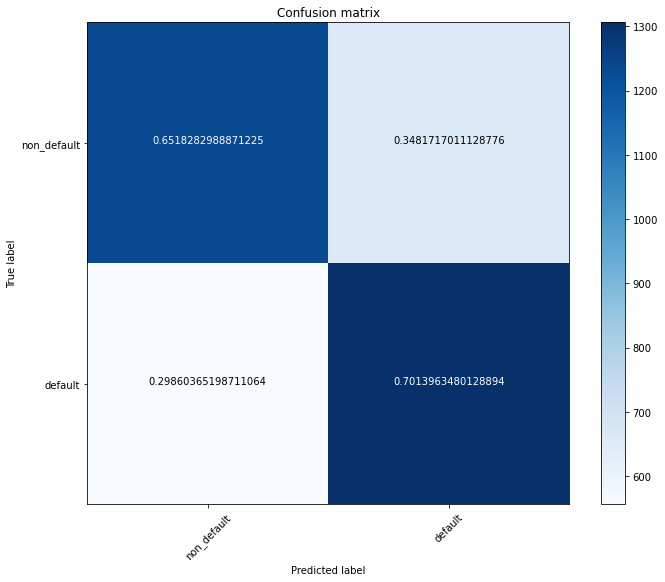

In [48]:
get_metrics(Y_test, Y_pred)


plot_roc_auc(Y_test, Y_prob)


plot_pr_curve(Y_test, Y_prob)


cnf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], title='Confusion matrix')
plt.show()

## XGBoost + Regularization

In [49]:
# param_grid = {'n_estimators':[20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
#               'eta': [0.01, 0.02, 0.03, 0.04],
#               'max_depth' : [6, 7, 8,  9, 10],
#               'sampling_method': ['uniform'],
#               'tree_method': ['auto']}

# model = XGBClassifier()
# clf = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, verbose=True)

# best_model = clf.fit(X_train, Y_train)
# best_model = best_model.best_estimator_.get_params()

# eta = best_model['eta']
# n_estimators = best_model['n_estimators']
# max_depth = best_model['max_depth']

# best_model

In [50]:
# model = XGBClassifier(n_jobs= -1,
#                       random_state=RANDOM_SEED,
#                       eta = eta,
#                       max_depth = max_depth,
#                       n_estimators = n_estimators,
#                       sampling_method = 'uniform',
#                       tree_method = 'auto')

# model.fit(X_train, Y_train)

# # Prediction
# Y_pred = model.predict(X_test)

# # Probability
# Y_prob = model.predict_proba(X_test)
# Y_prob = Y_prob[:, 1]

## RandomForestClassifier + Regularization

In [51]:
# param_grid = {'n_estimators':[20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
#               'max_depth' : [6, 7, 8,  9, 10],
#               'max_features': ['auto'],
#               'max_leaf_nodes': [9, 10, 11],
#               'oob_score': [False],
#               'ccp_alpha': [0.0, 0.01, 0.05, 1]
#              }

# model = RandomForestClassifier()
# clf = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, verbose=True)

# best_model = clf.fit(X_train, Y_train)
# best_model = best_model.best_estimator_.get_params()

# n_estimators = best_model['n_estimators']
# max_depth = best_model['max_depth']
# max_leaf_nodes = best_model['max_leaf_nodes']
# ccp_alpha = best_model['ccp_alpha']

# best_model

In [52]:
# model = RandomForestClassifier(n_jobs= -1,
#                                random_state=RANDOM_SEED,
#                                max_depth = max_depth,
#                                n_estimators = n_estimators,
#                                max_leaf_nodes = max_leaf_nodes,
#                                ccp_alpha = ccp_alpha,
#                                max_features = 'auto')

# model.fit(X_train, Y_train)

# # Prediction
# Y_pred = model.predict(X_test)

# # Probability
# Y_prob = model.predict_proba(X_test)
# Y_prob = Y_prob[:, 1]

## Submission

In [53]:
test_data.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_date_month,app_date_day,ACD,GRD,PGR,SCH,UGR,NaN,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,age_norm,age_log,age_log_norm,decline_app_cnt_norm,decline_app_cnt_log,decline_app_cnt_log_norm,score_bki_norm,score_bki_log,score_bki_log_norm,bki_request_cnt_norm,bki_request_cnt_log,bki_request_cnt_log_norm,income_norm,income_log,income_log_norm,decline_app_cnt_group,no_decline,1_decline,mm_decline
75913,86282,2014-04-02,4,0,58,0,0,1,0,1.721074,1,50,2,3,22000,2,3,0,0,4,2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1.627937,4.077537,1.483906,0.909522,0.693147,1.499512,-0.367493,1.001027,-0.271454,-0.443335,0.693147,-0.281790,-0.418785,9.998843,-0.498037,1,0,1,0
74339,52821,2014-03-01,1,0,33,0,0,0,0,2.194838,2,70,1,3,35000,1,3,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,-0.542577,3.526361,-0.449689,-0.341893,0.000000,-0.418815,0.581373,1.161536,0.610422,-0.002207,1.098612,0.333797,-0.132439,10.463132,0.168439,0,1,0,0
80466,12072,2014-01-19,3,1,26,0,0,4,0,1.620315,1,40,2,3,23000,3,3,0,0,1,19,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,-1.150321,3.295837,-1.258393,4.663765,1.609438,4.035403,-0.569295,0.963295,-0.478763,-0.443335,0.693147,-0.281790,-0.396758,10.043293,-0.434230,2,0,0,1


In [54]:
predict_submission = pd.DataFrame(test_data['client_id'])

In [55]:
test_data = test_data.drop(drop_list, axis=1)

In [56]:
probs = model.predict_proba(test_data)
predict_submission['default'] = probs[:,1]

In [57]:
predict_submission.head(3)

,client_id,default
73799,74835,0.231041
73800,17527,0.658843
73801,75683,0.362031


In [58]:
predict_submission.to_csv('submission.csv', index=False)